# Most Popular Data Science Topic
The goal of this project is to use Data Science Stack Exchange to determine the most popular topic(s) in Data Science.
## Getting the Data
Stack Exchange provides a public data base for each of its websites. The Data Science Stack Exchange database can be queried and explored [here](https://data.stackexchange.com/datascience/query/new) More information about Stack Exchange Data Explorer (SEDE) can be found on its [help section](https://data.stackexchange.com/help).

To get the necessary data I'll run the following query.

`SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;`
 
 

## Exploring the Data

In [41]:
# I'll import everything that I'll use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [42]:
# Read in the data while immediately making sure CreationDate will be stored as a datetime object:

questions = pd.read_csv("QueryResults.csv", parse_dates=["CreationDate"])

In [43]:
# View Data

questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
2517,63836,2019-11-27 08:08:34,0,33,<deep-learning><loss-function><object-detectio...,0,NaN
2419,63691,2019-11-24 18:40:26,0,9,<r><plotting><confusion-matrix>,0,NaN
4763,64583,2019-12-10 18:31:43,7,144,<deep-learning><bert><finetuning>,1,1.0


Looks like `Tags` needs some string cleaning

In [44]:
# Explore data

questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8115 non-null   int64         
 1   CreationDate   8115 non-null   datetime64[ns]
 2   Score          8115 non-null   int64         
 3   ViewCount      8115 non-null   int64         
 4   Tags           8115 non-null   object        
 5   AnswerCount    8115 non-null   int64         
 6   FavoriteCount  1513 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 443.9+ KB


It looks like `FavoriteCount` is missing data. A missing value on this column probably means that the question was is not present in any users' favorite list, so I'll replace the missing values with zero, and store as `int` since there is no reason to store as floats. The types seem adequate for every column.

## Data Cleaning
I'll begin by fixing `FavoriteCount`.

In [45]:
questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

Now I'll modify `Tags` to make it easier to work with.

In [46]:
questions['Tags'] = questions['Tags'].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
6952,61726,2019-10-14 17:13:25,0,30,"[nlp, convnet, sentiment-analysis]",2,0
4369,60487,2019-09-20 09:35:15,0,78,"[python, keras, tensorflow]",3,0
7666,53902,2019-06-16 14:33:51,0,29,"[python, keras, tensorflow, feature-engineering]",0,0


## Determine Popularity

I'll now determine the most popular topics in data science. I'll do so by considering two different popularity proxies: for each tag I'll count how many times the tag was used, and how many times a question with that tag was viewed.

In [53]:
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

For improved aesthetics, I'll transform tag_count in a dataframe.

In [54]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
python,1679
pandas,341
predictive-modeling,250
data,195
random-forest,147
categorical-data,77
pca,82
machine-learning,2499
word-embeddings,112
convolution,91


Now I'll sort this dataframe by Count and visualize the top 20 results.

In [55]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

,Count
machine-learning-model,209
statistics,214
clustering,250
predictive-modeling,250
r,252
dataset,308
regression,321
pandas,341
lstm,355
time-series,419


The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data.

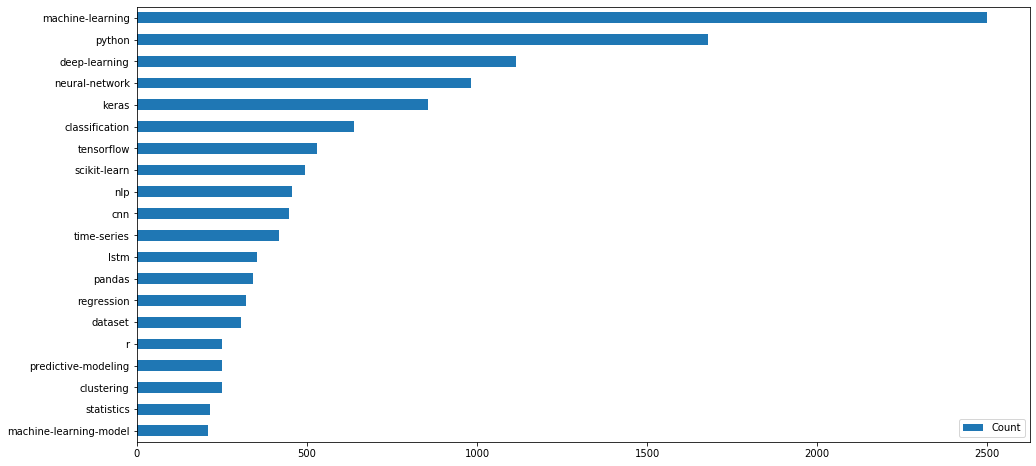

In [65]:
most_used.plot(kind = 'barh', figsize = (16,8))

Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before I investigate the tags a little deeper, I'll repeat the same process for views using pandas's pandas.DataFrame.iterrows().

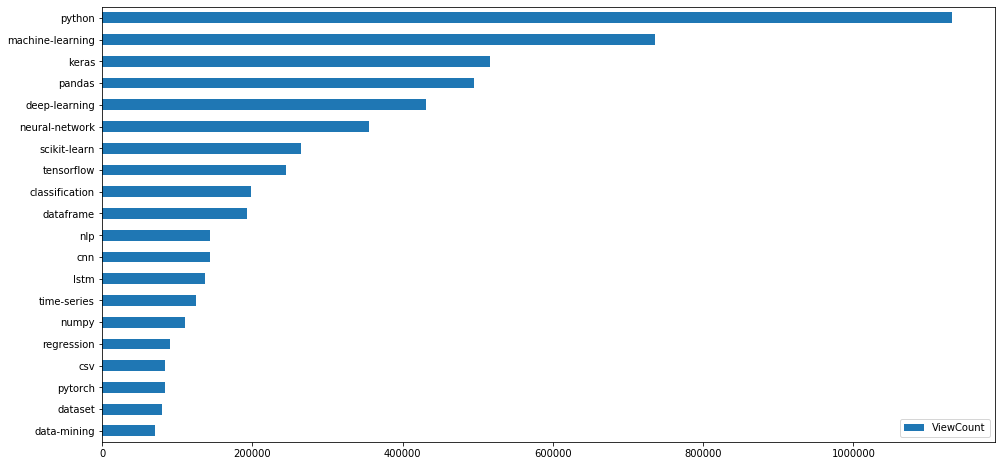

In [85]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

most_viewed.plot(kind="barh", figsize=(16,8))

Now I'll look at the plots side by side.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a199fa390>],
      dtype=object)

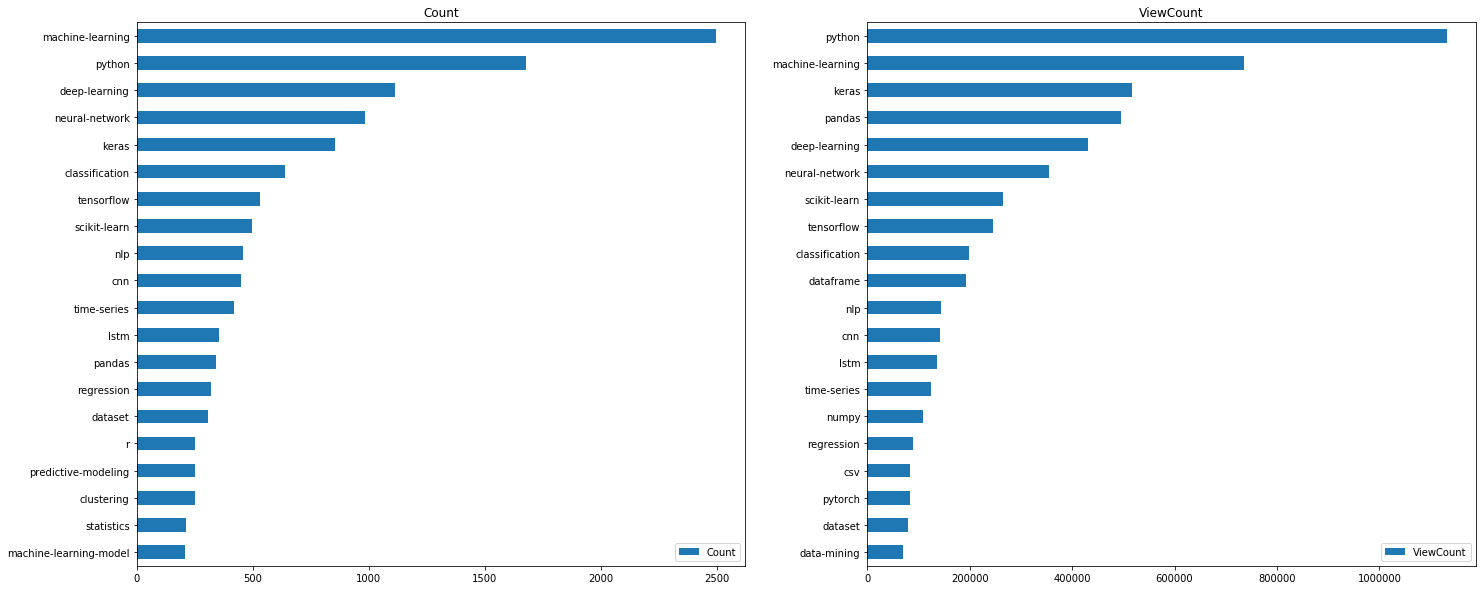

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

## Conclusions 
Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).
Most of the top tags are all intimately related with one central machine learning theme: deep learning. 
The most popular topic at the moment, as shown by my analysis, is deep learning.